In [3]:
# Yile Shen
# 3/7/2024
# Advanced Programming: AIML
# Osu playing robot

# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import math

from tqdm import tqdm

# couple notes: i chose to switch to pytorch as I was more comfortable with it
# and I needed to customize my model in a lot of ways, and I couldn't
# adequately get tensorflow to work.

# I also already had a really good setup for pytorch and I spent more time
# tuning the gpu usage on tensorflow. Pytorch also saved WAY more memory overall.

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# print name
print(torch.cuda.get_device_name(device))

# i had a tensorflow version, but I couldn't get some things to work in it
# so I switched to pytorch because I'm more comfortable with it and can do more.

#process images here so I can change resolution whenever
#
# FOLDER_PATH = "C:/Users/Yile0/PycharmProjects/osutime/frames/"
#
# for i in range(14, 5379):
#     img = cv2.imread(FOLDER_PATH + str(i)+".png")
#     img = cv2.resize(img, (160, 120), interpolation=cv2.INTER_AREA)
#     cv2.imwrite(FOLDER_PATH + str(i)+".png", img)
# making a custom image dataset class for pytorch
# originally had a custom dataset maker, but the dataloader is way better
# and formats them better.



NVIDIA GeForce RTX 4070


In [4]:
# compile dataset.
dataset_path = "C:/Users/Yile0/PycharmProjects/osutime/map1_data.csv"
data = pd.read_csv(dataset_path)

print(data.head())
print(data.columns)
# small data for changing, basically just for trialing new changes.
small_data = sklearn.utils.resample(data, n_samples= 1000)

# frame 4 is the latest/ most recent.

#originally these were one piece, changed for the dataloader to function
processed_data = []
processed_labels = []


def process_img(paths):
    # I had another self-made thing here that I decided to replace with premade functions
    images = []
    transform = transforms.Compose([transforms.ToTensor()])
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        # 100 by 75 because slightly better quality
        # over 80 by 60
        img = cv2.resize(img, (120, 68), interpolation=cv2.INTER_AREA)
        img_normalized = cv2.normalize(img, None, 0, 1.0,
                                       cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images.append(transform(img_normalized))
    out = torch.stack(images)
    # i played with trying to reshape to 120 16, but I came back
    # to this resolution because it was just so much better and faster
    # with regards to my training speed.
    out = out.reshape(len(paths),68,120)
    # played with preloading here and loading later, seems like loading later is better.
    # img = torch.from_numpy(img)
    return out


for index, row in tqdm(data.iterrows()):
    # trying without normalization.
    processed_labels.append([row['x'], row['y']])
    # try to predict just on 1 frame for testing
    processed_data.append(process_img([row['frame 4'],row['frame 3'],row['frame 2'],row['frame 1']]))


X_train, X_test, y_train, y_test = train_test_split(processed_data, processed_labels, test_size=0.1, random_state=42)

          x         y                                            frame 4  \
0  253.3333  256.4445  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  253.3333  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 3  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 2  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osut

8930it [01:52, 79.57it/s]


In [5]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, imageTransform=None, num_workers=0):
        self.imageTransform = imageTransform
        self.num_workers = num_workers
        self.imgs = images
        self.targets = labels

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        target = self.targets[idx]
        label = torch.Tensor(target)

        return image, label

In [6]:
# Creating a CNN class
# conv neural net combined was bad, this iteration separates them
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        # adjusted the first pooling to be 4 instead.
        # tried second pooling to be 4 too

        self.conv_layer1 = nn.Conv2d(in_channels=4, out_channels=512, kernel_size=4)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer4 = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=4)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(256, 128)
        # originally tried relu layers, but wanted something non-linear
        # went back because elu wasn't doing better
        # had 3 layers to begin with, then tried 4, then tried 7
        # I one off tried 13 but it didn't fit.=
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128, 1)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 1)
        # self.relu7 = nn.ReLU()
        # self.fc8 = nn.Linear(75, 1)
        # self.relu8 = nn.ReLU()
        # self.fc9 = nn.Linear(25, 1)
        # self.relu9 = nn.ReLU()
        # self.fc10 = nn.Linear(50, 1)
    # Progresses data across layers
    def forward(self, input):
        out_x = self.conv_layer1(input)
        out_x = self.relu(out_x)
        out_x = self.max_pool1(out_x)
        out_x = self.conv_layer2(out_x)
        out_x = self.relu(out_x)
        out_x = self.max_pool2(out_x)

        out_x = self.conv_layer3(out_x)
        out_x = self.relu(out_x)
        out_x = self.max_pool3(out_x)
        out_x = self.conv_layer4(out_x)
        out_x = self.relu(out_x)
        out_x = self.max_pool4(out_x)

        out_x = out_x.reshape(out_x.size(0), -1)
        
        out_x = self.fc1(out_x)
        out_x = self.sigmoid(out_x)
        out_x = self.fc2(out_x)
        out_x = self.sigmoid(out_x)
        out_x = self.fc3(out_x)
        out_x = self.sigmoid(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)

        return out_x

In [7]:
# Define relevant variables for the ML task
# tried batch sizes of 32 and 128 as well, but this was best
# 128 had better cuda utilization but didn't boost speed too much.
# decided it was more worth it to have better accuracy because 128 could
# introduce inaccuracies.
# after adding a few new layers 64 wasn't enough to have fast epochs
# so I decided to move to 128.
# accidentally tried batch size of 1, was way too inefficient
batch_size = 80
# originally learning rate was 0.001, but im making it learn longer and slower.
# makes me wonder if my original idea would have worked, but now it's too late to fix it.
# 0.001 basically didn't learn. I trained for somwhere around 500 epochs and loss basiclly didn't change
# from now on, I ran some 20 epoch experiments.
# 0.0001 was learning a lot to start, but loss seems to cycle between 0.10 and 0.13 or so

# 0.00001 had loss settle at around 0.28/0.3, which is maybe due to the lack of time it had to train.
# loss was generally going down even at 50 epochs, can't tell without a longer experiment.
# i'm going to keep it at this and train for 100 and see what happens.
# doesn't seem to improve past loss = 0.11

# running a 400 epoch experiment with learning rate 0.000001
learning_rate = 0.00001
# ran a few experiments on 20 epochs to see if it would learn.
num_epochs = 125
device = "cuda"

In [8]:
dataset = ImageDataset(X_test, y_train)
test = ImageDataset(X_test, y_test)

# added workers to speedup epoch time.
# 3 is the max tolerable it seems.
data_loader = DataLoader(dataset, batch_size=batch_size)


# model = ConvNeuralNet(2, train_data.shape[0])

# Set Loss function with criterion

model_x = ConvNeuralNet(2)
model_x.cuda(device)
# adam is just better, tried other optimizers like sgd though
optimizer_x = torch.optim.Adam(model_x.parameters(), lr=learning_rate)

model_y = ConvNeuralNet(2)
model_y.cuda(device)
# adam is just better, tried other optimizers like sgd though

optimizer_y = torch.optim.Adam(model_y.parameters(), lr=learning_rate)
# MSE loss instead of L1, which is squared loss vs linear loss.
# Huber over both, has the benefits of both.
criterion = nn.MSELoss()
epoch_start = 0


epoch_start = 0
# added code that allows it to train again from a checkpoint
# it lets me train in chunks over time.
# checkpoint = torch.load('model.pth')
# model_x.load_state_dict(checkpoint['model_x_state_dict'])
# optimizer_x.load_state_dict(checkpoint['optimizer_x_state_dict'])
# model_y.load_state_dict(checkpoint['model_y_state_dict'])
# optimizer_y.load_state_dict(checkpoint['optimizer_y_state_dict'])
# epoch_start = checkpoint['epoch']
# loss = checkpoint['loss']

# Set optimizer with optimizer

total_step = len(processed_data)

model_x.train()
model_y.train()

losses_x = []
losses_y = []
losses_val_x = []
losses_val_y = []

lr_y = []
lr_x = []

In [ ]:
import gc
def main():
    gc.collect()
    torch.cuda.empty_cache()
    for epoch in range(epoch_start, num_epochs):
        start = time.time()
        model_x.train()
        model_y.train()
        # Load in the data in batches using the train_loader object
        for i, (images, labels) in enumerate(tqdm(data_loader, desc = "Epoch " + str(epoch+1), miniters=10)):
            images = images.cuda(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            labels = labels.cuda(device)
            x_labels = labels[:, 0].unsqueeze(1)
            x_labels.requires_grad = True
            x_labels = x_labels.cuda(device)
            y_labels = labels[:, 1].unsqueeze(1)
            y_labels.requires_grad = True
            y_labels = y_labels.cuda(device)
            # Forward pass
            output_x = model_x(images) * 512
            loss_x = criterion(output_x, x_labels)
            output_y = model_y(images) * 384
            loss_y = criterion(output_y, y_labels)
            # Backward and optimize
            optimizer_y.zero_grad()
            optimizer_x.zero_grad()
            # had tried to combined, but now i'm just completely
            # separating the two models.
            loss_x.backward()
            loss_y.backward()
            optimizer_y.step()
            optimizer_x.step()
        # added checkpoint saver
        if (epoch + 1) % 6 == 0:
            torch.save({
                'epoch': epoch,
                'model_x_state_dict': model_x.state_dict(),
                'optimizer_x_state_dict': optimizer_x.state_dict(),
                'model_y_state_dict': model_y.state_dict(),
                'optimizer_y_state_dict': optimizer_y.state_dict(),
                'loss': criterion,
            }, "model.pth")
        model_x.eval()
        model_y.eval()
        for i, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            labels = labels.to(device)
            x_labels = labels[:, 0].unsqueeze(1)
            y_labels = labels[:, 1].unsqueeze(1)
            # Forward pass
            output_x = model_x(images) * 512
            loss_x_valid = criterion(output_x, x_labels)
            output_y = model_y(images) * 384
            loss_y_valid = criterion(output_y, y_labels)

        print('x val')
        print(x_labels)
        print(output_x)
        print('y val')
        print(y_labels)
        print(output_y)

        # step lr scheduler
        # add so I can graph later
        losses_x.append(loss_x.item())
        losses_y.append(loss_y.item())
        losses_val_x.append(loss_x_valid.item())
        losses_val_y.append(loss_y_valid.item())
        print('validate Loss_X: {:.10f}, validate Loss_y : {:.10f}'.format( loss_x_valid.item(), loss_y_valid.item()))

        end = time.time()
        print('Epoch [{}/{}], Loss1: {:.10f}, Loss2 : {:.4f} Time: {:.10f}'.format(epoch + 1, num_epochs, loss_x.item(), loss_y.item(), end-start))

    torch.save({
                    'epoch': num_epochs,
                    'model_x_state_dict': model_x.state_dict(),
                    'optimizer_x_state_dict': optimizer_x.state_dict(),
                    'model_y_state_dict': model_y.state_dict(),
                    'optimizer_y_state_dict': optimizer_y.state_dict(),
                    'loss': criterion,
                }, "model.pth")


if __name__ == '__main__':
    main()

Epoch 1: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


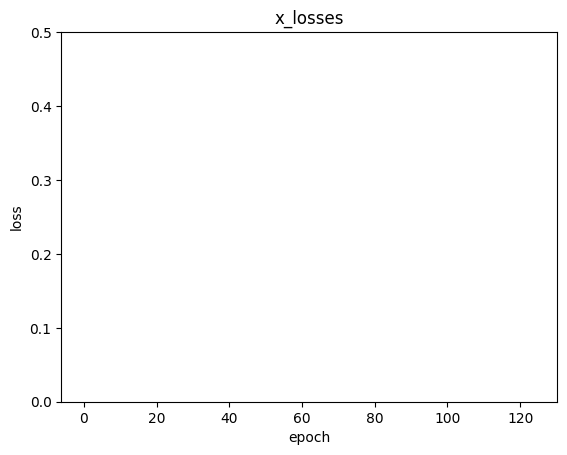

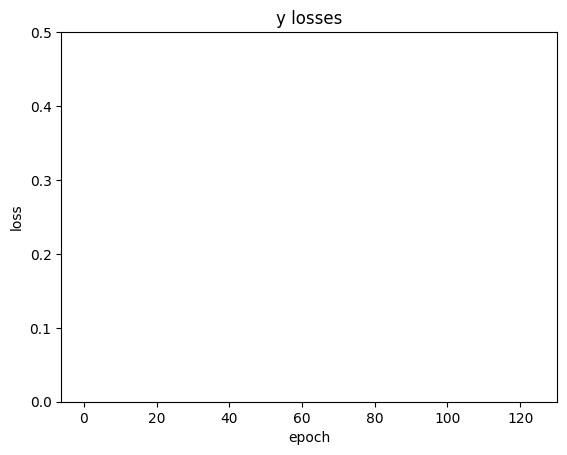

ValueError: x and y must have same first dimension, but have shapes (125,) and (0,)

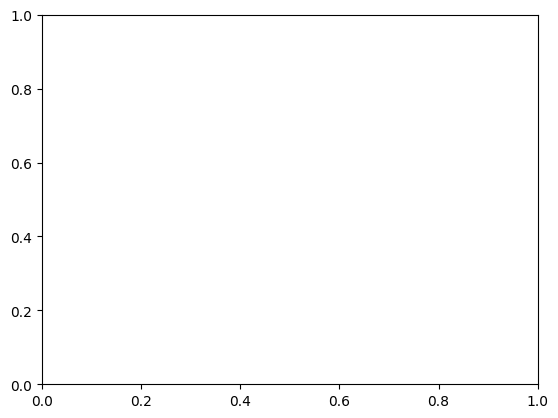

In [10]:
plt.plot(list(range(epoch_start, num_epochs)), losses_x)
plt.plot(list(range(epoch_start, num_epochs)), losses_val_x, '-.')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('x_losses')
plt.ylim(0, 0.5)
plt.show()

plt.plot(list(range(epoch_start, num_epochs)), losses_y)
plt.plot(list(range(epoch_start, num_epochs)), losses_val_y, '-.')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('y losses')
plt.ylim(0, 0.5)
plt.show()

plt.plot(list(range(epoch_start, num_epochs)), lr_x)
plt.plot(list(range(epoch_start, num_epochs)), lr_y, '-.')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('learning rate')
plt.ylim(0, 0.5)
plt.show()



# with torch.no_grad():
#     correct = 0
#     total = 0
#     for i, (labels, images) in enumerate(processed_data):
#         images = images.reshape((1, 4, 60, 80))
#         images = images.to(device)
#         labels = torch.tensor(labels, dtype=torch.float32)
#         labels = labels.to(device)
#         outputs = model(images)
#         print([labels[0], labels[1]], [outputs[0], outputs[1]])


